In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler

T = 24
HIDDEN_DIM = 256
OUTPUT_DIM = 2
LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 80
WEIGHT_DECAY = 1e-5
SURROGATE_GRADIENT_BETA = 10.0

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if not torch.cuda.is_available():
    raise RuntimeError("CUDA GPU not available!")
DEVICE = torch.device("cuda:0")

In [3]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def load_and_preprocess(csv_path, label_col="Class/ASD", test_size=0.2, val_size=0.1, random_state=42):
    df = pd.read_csv(csv_path)
    df = df.dropna(axis=0, how='all').reset_index(drop=True)

    if df[label_col].dtype == 'object':
        le_target = LabelEncoder()
        df[label_col] = le_target.fit_transform(df[label_col].astype(str))

    for col in df.columns:
        if col != label_col and df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    for col in df.columns:
        if df[col].dtype in ["int64", "float64"]:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

    y = df[label_col].values.astype(int)
    X = df.drop(columns=[label_col]).values.astype(float)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    from sklearn.model_selection import train_test_split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    val_relative = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_relative, stratify=y_train_full, random_state=random_state
    )

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                           torch.tensor(y_val, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader, X.shape[1]


In [5]:
class SurrogateSpikeFunction(torch.autograd.Function):
    def forward(ctx, input, beta):
        ctx.save_for_backward(input)
        ctx.beta = beta
        return (input > 0).float()

    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        beta = ctx.beta
        sigmoid = torch.sigmoid(beta * input)
        grad_input = grad_output * beta * sigmoid * (1 - sigmoid)
        return grad_input, None

surrogate_spike = SurrogateSpikeFunction.apply

In [6]:
class LIFLayer(nn.Module):
    def __init__(self, input_size, hidden_size, tau_mem=20.0, tau_ref=2.0, surrogate_beta=SURROGATE_GRADIENT_BETA, dropout=0.2):
        super().__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        self.alpha = torch.tensor(math.exp(-1.0 / tau_mem))
        self.tau_ref = tau_ref
        self.surrogate_beta = surrogate_beta
        self.dropout = nn.Dropout(dropout)
        nn.init.kaiming_normal_(self.fc.weight, nonlinearity='linear')
        nn.init.constant_(self.fc.bias, 0.0)
    def forward(self, input_t, mem, ref):
        i_t = self.fc(self.dropout(input_t))
        new_mem = self.alpha * mem + i_t
        mask_refractory = (ref <= 0).float()
        mem_for_spike = new_mem * mask_refractory
        m_minus_thr = mem_for_spike - 1.0
        spikes = surrogate_spike(m_minus_thr, self.surrogate_beta)
        new_mem = new_mem * (1.0 - spikes)
        new_ref = torch.clamp(ref - 1.0, min=0.0)
        new_ref = torch.where(spikes > 0.0, torch.tensor(float(self.tau_ref), device=new_ref.device), new_ref)
        return spikes, new_mem, new_ref

In [7]:
class SNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, time_steps=T, depth=4):
        super().__init__()
        self.time_steps = time_steps
        self.depth = depth
        self.layers = nn.ModuleList()
        self.layers.append(LIFLayer(input_dim, hidden_dim))
        for _ in range(depth - 1):
            self.layers.append(LIFLayer(hidden_dim, hidden_dim))
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        batch_size = x.shape[0]
        mems = [torch.zeros(batch_size, HIDDEN_DIM, device=x.device) for _ in range(self.depth)]
        refs = [torch.zeros(batch_size, HIDDEN_DIM, device=x.device) for _ in range(self.depth)]
        spike_sums = torch.zeros(batch_size, HIDDEN_DIM, device=x.device)
        for t in range(self.time_steps):
            input_t = x
            for i, layer in enumerate(self.layers):
                spikes, mems[i], refs[i] = layer(input_t, mems[i], refs[i])
                input_t = spikes + input_t if input_t.shape == spikes.shape else spikes
            spike_sums += input_t
        features = spike_sums / float(self.time_steps)
        logits = self.readout(features)
        return logits

In [8]:
def _is_multiclass_output(sample_out):
    out = sample_out.detach().cpu().numpy()
    return out.ndim == 2 and out.shape[1] > 1

def _prepare_label_tensor(yb, use_long):
    if use_long:
        return yb.long().to(DEVICE)
    else:
        return yb.float().unsqueeze(1).to(DEVICE)


In [9]:
def train_one_epoch(model, loader, optimizer, criterion, is_multiclass):
    model.train()
    losses = []
    use_long = isinstance(criterion, nn.CrossEntropyLoss)
    for Xb, yb in loader:
        Xb = Xb.to(DEVICE)
        yb_t = _prepare_label_tensor(yb, use_long)
        optimizer.zero_grad()
        out = model(Xb)
        if is_multiclass:
            loss = criterion(out, yb_t)
        else:
            if out.ndim == 2 and out.shape[1] == 1:
                if isinstance(criterion, (nn.BCEWithLogitsLoss, nn.BCELoss)):
                    loss = criterion(out.squeeze(1), yb_t.squeeze(1))
                else:
                    loss = criterion(out.squeeze(1), yb_t.squeeze(1))
            else:
                loss = criterion(out, yb_t)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))
    return float(np.mean(losses)) if losses else 0.0


In [10]:
def evaluate(model, loader, criterion, is_multiclass):
    model.eval()
    losses, y_true, y_pred, y_prob = [], [], [], []
    use_long = isinstance(criterion, nn.CrossEntropyLoss)
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(DEVICE)
            yb_t = _prepare_label_tensor(yb, use_long)
            out = model(Xb)
            if is_multiclass:
                loss = criterion(out, yb_t)
                probs = torch.softmax(out, dim=1).detach().cpu().numpy()
                preds = np.argmax(probs, axis=1)
                probs = probs[:,1] if probs.shape[1] > 1 else probs.reshape(-1)
            else:
                if out.ndim == 2 and out.shape[1] == 1:
                    if isinstance(criterion, (nn.BCEWithLogitsLoss, nn.BCELoss)):
                        loss = criterion(out.squeeze(1), yb_t.squeeze(1))
                        probs = torch.sigmoid(out).detach().cpu().numpy().reshape(-1)
                    else:
                        loss = criterion(out.squeeze(1), yb_t.squeeze(1))
                        probs = torch.sigmoid(out).detach().cpu().numpy().reshape(-1)
                else:
                    loss = criterion(out, yb_t)
                    probs = torch.sigmoid(out).detach().cpu().numpy().reshape(-1) if out.ndim==2 else out.detach().cpu().numpy().reshape(-1)
                preds = (probs > 0.5).astype(int)
            losses.append(float(loss.detach().cpu().item()))
            y_true.extend(yb.detach().cpu().numpy().tolist())
            y_pred.extend(preds.tolist())
            if isinstance(probs, (list, np.ndarray)):
                y_prob.extend(probs.tolist())
            else:
                y_prob.append(float(probs))
    avg_loss = float(np.mean(losses)) if losses else 0.0
    return avg_loss, np.array(y_true), np.array(y_pred), np.array(y_prob)


In [11]:
import numpy as np
import torch

def compute_class_weights(obj):
    if isinstance(obj, torch.utils.data.DataLoader):
        dataset = obj.dataset
    else:
        dataset = obj
    if hasattr(dataset, "tensors"):
        y_tensor = dataset.tensors[1]
    elif hasattr(dataset, "datasets"): 
        ds = dataset
        while hasattr(ds, "dataset"):
            ds = ds.dataset
        if hasattr(ds, "tensors"):
            y_tensor = ds.tensors[1]
        else:
            raise ValueError("Unsupported dataset structure")
    else:
        raise ValueError("Unsupported dataset type")
    y = y_tensor.detach().cpu().numpy().astype(int)
    classes, counts = np.unique(y, return_counts=True)
    N = len(y)
    C = len(classes)
    weights = np.zeros(C, dtype=np.float32)
    for i, c in enumerate(classes):
        weights[c] = float(N / (C * counts[i]))
    return torch.tensor(weights, dtype=torch.float32).to(DEVICE)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

def plot_results(history, test_stats, y_true, y_pred, y_probs):
    metrics_table = pd.DataFrame([test_stats])
    print("Performance Metrics Table:")
    display(metrics_table)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_probs)
    plt.title("ROC Curve")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.show()

In [13]:
def run_training(csv_path, label_col="Class/ASD", save_path="best_model.pt", epochs=50, lr=1e-3, weight_decay=1e-5):
    try:
        train_loader, val_loader, test_loader, input_dim = load_and_preprocess(csv_path, label_col=label_col)
    except Exception:
        train_loader, val_loader, test_loader, input_dim = load_and_preprocess(csv_path, label_col=label_col)

    ModelClass = SNN if "SNN" in globals() else (MLP if "MLP" in globals() else None)
    if ModelClass is None:
        raise RuntimeError("No model class found (SNN or MLP required)")

    model = ModelClass(input_dim=input_dim).to(DEVICE)
    sample_batch = next(iter(train_loader))[0].to(DEVICE)
    with torch.no_grad():
        sample_out = model(sample_batch)

    is_multiclass = _is_multiclass_output(sample_out)

    if is_multiclass:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = {"train_loss": [], "val_loss": []}
    best_val_f1 = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, is_multiclass)
        val_loss, y_true_val, y_pred_val, y_prob_val = evaluate(model, val_loader, criterion, is_multiclass)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        from sklearn.metrics import f1_score
        val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)

        print(f"Epoch {epoch:02d} Train loss {train_loss:.4f} Val loss {val_loss:.4f} Val F1 {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {"model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(), "epoch": epoch, "val_f1": val_f1}
            torch.save(best_state, save_path)

    if best_state is not None:
        model.load_state_dict(best_state["model_state"])

    test_loss, y_true_test, y_pred_test, y_prob_test = evaluate(model, test_loader, criterion, is_multiclass)

    test_acc = accuracy_score(y_true_test, y_pred_test)
    test_prec = precision_score(y_true_test, y_pred_test, zero_division=0)
    test_rec = recall_score(y_true_test, y_pred_test, zero_division=0)
    test_f1 = f1_score(y_true_test, y_pred_test, zero_division=0)
    test_auc = roc_auc_score(y_true_test, y_prob_test) if len(np.unique(y_true_test))>1 else float('nan')

    test_stats = {"acc": test_acc, "prec": test_prec, "rec": test_rec, "f1": test_f1, "auc": test_auc}
    globals().update({"history": history, "y_true_test": y_true_test, "y_pred_test": y_pred_test, "y_prob_test": y_prob_test, "trained_model": model})
    print("Test results:", test_stats)
    return model, test_stats


In [14]:
csv_path = r"F:\Dataset\Autism-Adult-Data.csv"
model, stats = run_training(csv_path, label_col="Class/ASD")

Epoch 01 Train loss 0.6134 Val loss 0.4311 Val F1 0.9677
Epoch 02 Train loss 0.3476 Val loss 0.1880 Val F1 0.9375
Epoch 03 Train loss 0.1593 Val loss 0.0808 Val F1 0.9655
Epoch 04 Train loss 0.0632 Val loss 0.0326 Val F1 1.0000
Epoch 05 Train loss 0.0300 Val loss 0.0376 Val F1 0.9655
Epoch 06 Train loss 0.0154 Val loss 0.0060 Val F1 1.0000
Epoch 07 Train loss 0.0060 Val loss 0.0021 Val F1 1.0000
Epoch 08 Train loss 0.0025 Val loss 0.0017 Val F1 1.0000
Epoch 09 Train loss 0.0016 Val loss 0.0009 Val F1 1.0000
Epoch 10 Train loss 0.0012 Val loss 0.0007 Val F1 1.0000
Epoch 11 Train loss 0.0022 Val loss 0.0028 Val F1 1.0000
Epoch 12 Train loss 0.0007 Val loss 0.0227 Val F1 1.0000
Epoch 13 Train loss 0.0026 Val loss 0.0034 Val F1 1.0000
Epoch 14 Train loss 0.0018 Val loss 0.0026 Val F1 1.0000
Epoch 15 Train loss 0.0004 Val loss 0.0041 Val F1 1.0000
Epoch 16 Train loss 0.0005 Val loss 0.0053 Val F1 1.0000
Epoch 17 Train loss 0.0005 Val loss 0.0049 Val F1 1.0000
Epoch 18 Train loss 0.0005 Val 

,Model,Accuracy,Precision,Recall,F1,AUC
0,SNN,1.0,1.0,1.0,1.0,1.0


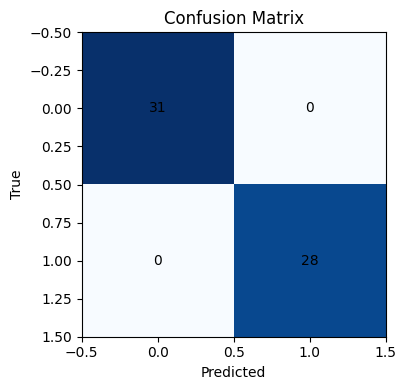

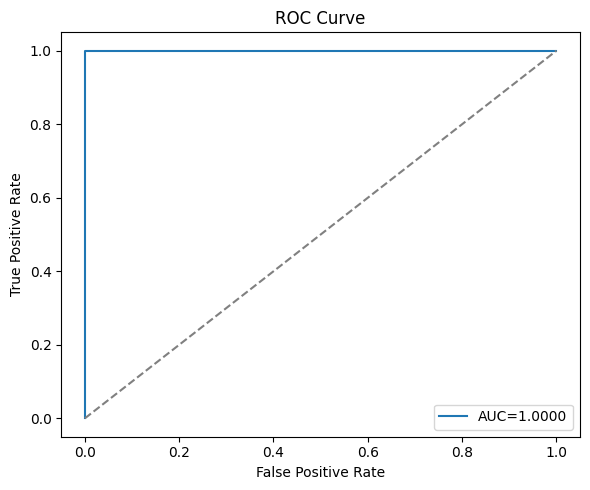

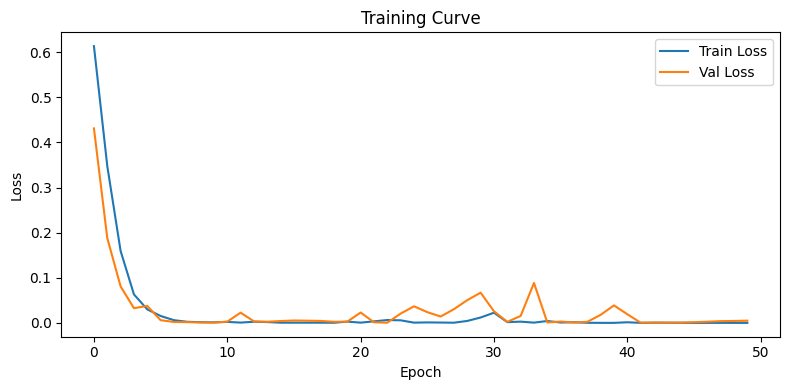

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

def _safe_probs(y_pred_prob):
    if y_pred_prob is None:
        return None
    arr = np.array(y_pred_prob)
    if arr.ndim == 2 and arr.shape[1] > 1:
        arr = arr[:,1]
    if arr.ndim == 2 and arr.shape[1] == 1:
        arr = arr.reshape(-1)
    if arr.dtype == object:
        try:
            arr = arr.astype(float)
        except Exception:
            return None
    if np.isnan(arr).all():
        return None
    if np.nanmax(arr) > 1.0 or np.nanmin(arr) < 0.0:
        from scipy.special import expit
        arr = expit(arr)
    return arr

def show_deepsnn_results(trained_model=None, history=None, y_true=None, y_pred=None, y_prob=None):
    if trained_model is None and 'trained_model' in globals():
        trained_model = globals()['trained_model']
    if history is None and 'history' in globals():
        history = globals()['history']
    if y_true is None and 'y_true_test' in globals():
        y_true = globals()['y_true_test']
    if y_pred is None and 'y_pred_test' in globals():
        y_pred = globals()['y_pred_test']
    if y_prob is None and 'y_prob_test' in globals():
        y_prob = globals()['y_prob_test']

    if y_true is None or y_pred is None:
        raise RuntimeError("y_true and y_pred not found. Provide them manually or ensure globals exist.")

    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    y_prob_arr = _safe_probs(y_prob)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = float('nan')
    if y_prob_arr is not None and len(np.unique(y_true)) > 1:
        try:
            auc = roc_auc_score(y_true, y_prob_arr)
        except Exception:
            auc = float('nan')

    df = pd.DataFrame([{"Model":"SNN","Accuracy":acc,"Precision":prec,"Recall":rec,"F1":f1,"AUC":auc}])
    display(df)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (r,c),val in np.ndenumerate(cm):
        plt.text(c, r, int(val), ha="center", va="center", color="black")
    plt.tight_layout()
    plt.show()

    if y_prob_arr is not None and len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob_arr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
        plt.plot([0,1],[0,1],"--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if history is not None and isinstance(history, dict):
        tl = history.get("train_loss")
        vl = history.get("val_loss")
        plt.figure(figsize=(8,4))
        if tl is not None: plt.plot(tl, label="Train Loss")
        if vl is not None: plt.plot(vl, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Curve")
        plt.legend()
        plt.tight_layout()
        plt.show()

show_deepsnn_results()

In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

def load_and_preprocess(csv_path, label_col="Class/ASD", test_size=0.2, val_size=0.1, random_state=42, batch_size=32):
    df = pd.read_csv(csv_path).dropna(axis=0, how="all").reset_index(drop=True)

    df = df.replace("?", "Unknown").fillna("Unknown")

    df[label_col] = df[label_col].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})

    for col in df.columns:
        if col != label_col and df[col].dtype == "object":
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    for col in df.columns:
        if df[col].dtype in ["int64", "float64"]:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

    y = df[label_col].values.astype(int)
    X = df.drop(columns=[label_col]).values.astype(float)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    val_relative = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_relative, stratify=y_train_full, random_state=random_state
    )

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, X.shape[1]


In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim//2, output_dim)
        )
    def forward(self, x):
        return self.net(x)

In [18]:
def run_training_mlp(csv_path, label_col="Class/ASD", save_path="mlp_autism.pt"):
    train_loader, val_loader, test_loader, input_dim = load_and_preprocess(csv_path, label_col=label_col)
    model = MLP(input_dim=input_dim).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    history = {"train_loss": [], "val_loss": []}
    best_state = None

    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_stats = evaluate(model, val_loader, criterion)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_stats["loss"])
        if best_state is None or val_stats["f1"] > evaluate(model, val_loader, criterion)["f1"]:
            best_state = {"model_state": model.state_dict()}
            torch.save(best_state, save_path)
        print(f"Epoch {epoch} Train {train_loss:.4f}/{train_acc:.4f} | Val {val_stats}")

    if best_state:
        model.load_state_dict(best_state["model_state"])

    test_stats = evaluate(model, test_loader, criterion)
    print("MLP Test Results:", test_stats)

    y_true, y_pred, y_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(DEVICE)
            logits = model(Xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            probs = F.softmax(logits, dim=1)[:,1].cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(yb.numpy().tolist())
            y_probs.extend(probs.tolist())

    plot_results(history, test_stats, y_true, y_pred, y_probs)
    return model, test_stats

In [19]:
def run_training_mlp(csv_path, label_col="Class/ASD", save_path="mlp_autism.pt", epochs=200, lr=0.00005, weight_decay=1e-5):
    train_loader, val_loader, test_loader, input_dim = load_and_preprocess(csv_path, label_col=label_col)
    model = MLP(input_dim=input_dim, hidden_dim=256, output_dim=2).to(DEVICE)
    sample_batch = next(iter(train_loader))[0].to(DEVICE)
    with torch.no_grad():
        sample_out = model(sample_batch)
    is_multiclass = _is_multiclass_output(sample_out)
    if is_multiclass:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = {"train_loss": [], "val_loss": []}
    best_val_f1 = -1.0
    best_state = None
    for epoch in range(1, epochs+1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, is_multiclass)
        val_loss, y_true_val, y_pred_val, y_prob_val = evaluate(model, val_loader, criterion, is_multiclass)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        from sklearn.metrics import f1_score, accuracy_score
        val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        print(f"Epoch {epoch:02d} Train {train_loss:.4f} | Val {val_loss:.4f} | Val Acc {val_acc:.4f} | Val F1 {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {"model_state": model.state_dict(),
                          "optimizer_state": optimizer.state_dict(),
                          "epoch": epoch,
                          "val_f1": val_f1}
            torch.save(best_state, save_path)
    if best_state is not None:
        model.load_state_dict(best_state["model_state"])
    test_loss, y_true_test, y_pred_test, y_prob_test = evaluate(model, test_loader, criterion, is_multiclass)
    test_stats = {
        "Accuracy": accuracy_score(y_true_test, y_pred_test),
        "Precision": precision_score(y_true_test, y_pred_test, zero_division=0),
        "Recall": recall_score(y_true_test, y_pred_test, zero_division=0),
        "F1": f1_score(y_true_test, y_pred_test, zero_division=0),
        "AUC": roc_auc_score(y_true_test, y_prob_test) if len(np.unique(y_true_test)) > 1 else float("nan")
    }
    print("Test Results:", test_stats)
    return model, test_stats

In [20]:
csv_path = r"F:\Dataset\Autism-Adult-Data.csv"

print("\n--- Training MLP ---")
mlp_model, mlp_stats = run_training_mlp(csv_path, label_col="Class/ASD")


--- Training MLP ---
Epoch 01 Train 0.6460 | Val 0.6683 | Val Acc 0.5333 | Val F1 0.2222
Epoch 02 Train 0.5725 | Val 0.6268 | Val Acc 0.7333 | Val F1 0.6923
Epoch 03 Train 0.5265 | Val 0.5714 | Val Acc 0.8333 | Val F1 0.8276
Epoch 04 Train 0.4939 | Val 0.5118 | Val Acc 0.8333 | Val F1 0.8276
Epoch 05 Train 0.4452 | Val 0.4658 | Val Acc 0.8667 | Val F1 0.8667
Epoch 06 Train 0.4155 | Val 0.4327 | Val Acc 0.8667 | Val F1 0.8667
Epoch 07 Train 0.4024 | Val 0.4052 | Val Acc 0.8667 | Val F1 0.8667
Epoch 08 Train 0.3798 | Val 0.3858 | Val Acc 0.8667 | Val F1 0.8667
Epoch 09 Train 0.3470 | Val 0.3769 | Val Acc 0.8667 | Val F1 0.8667
Epoch 10 Train 0.3205 | Val 0.3605 | Val Acc 0.8667 | Val F1 0.8667
Epoch 11 Train 0.3110 | Val 0.3490 | Val Acc 0.9000 | Val F1 0.8966
Epoch 12 Train 0.3108 | Val 0.3357 | Val Acc 0.8667 | Val F1 0.8667
Epoch 13 Train 0.2866 | Val 0.3293 | Val Acc 0.9000 | Val F1 0.8966
Epoch 14 Train 0.2811 | Val 0.3202 | Val Acc 0.8667 | Val F1 0.8667
Epoch 15 Train 0.2727 | Va

In [21]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

def run_xgboost(csv_path, label_col="Class/ASD", test_size=0.2, random_state=42):
    df = pd.read_csv(csv_path).dropna(axis=0, how="all").reset_index(drop=True)
    df = df.replace("?", "Unknown").fillna("Unknown")
    if df[label_col].dtype == object:
        lbl = df[label_col].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})
        if lbl.isnull().any():
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            df[label_col] = le.fit_transform(df[label_col].astype(str))
        else:
            df[label_col] = lbl.astype(int)
    else:
        df[label_col] = df[label_col].astype(int)
    y = df[label_col].values
    X = df.drop(columns=[label_col])
    obj_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    if len(obj_cols) > 0:
        X = pd.get_dummies(X, columns=obj_cols, drop_first=True)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) != X.shape[1]:
        X = X.astype(float)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=test_size, stratify=y, random_state=random_state)
    model = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, use_label_encoder=False, eval_metric="logloss", random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except Exception:
        y_prob = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_prob) if (y_prob is not None and len(np.unique(y_test))>1) else float("nan")
    except Exception:
        auc = float("nan")
    stats = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}
    print("XGBoost test stats:", stats)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    return model, stats

In [22]:
csv_path = r"F:\Dataset\Autism-Adult-Data.csv"

print("\n--- Training XGBoost ---")
xgb_model = run_xgboost(csv_path, label_col="Class/ASD")


--- Training XGBoost ---
XGBoost test stats: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0, 'AUC': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        28

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

Confusion matrix:
 [[31  0]
 [ 0 28]]


f:\Autism new\autism_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:37:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
def load_arrays(csv_path, label_col="Class/ASD"):
    df = pd.read_csv(csv_path)
    df = df.dropna(axis=0, how='all').reset_index(drop=True)
    df = df.fillna(df.mean())
    y = df[label_col].values.astype(int)
    X = df.drop(columns=[label_col]).values.astype(float)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

In [24]:
import numpy as np

class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=1000, l2=0.0, verbose=False, batch_size=None, momentum=0.0, lr_decay=0.0, early_stopping=False, tol=1e-4, patience=10, seed=42):
        self.lr = lr
        self.n_iter = n_iter
        self.l2 = l2
        self.verbose = verbose
        self.batch_size = batch_size
        self.momentum = momentum
        self.lr_decay = lr_decay
        self.early_stopping = early_stopping
        self.tol = tol
        self.patience = patience
        self.seed = seed
        self.w = None
        self.b = None
        self.v_w = None
        self.v_b = None

    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -50, 50)))

    def _loss(self, y, p):
        return -np.mean(y*np.log(p+1e-12) + (1-y)*np.log(1-p+1e-12)) + 0.5*self.l2*np.sum(self.w**2)

    def fit(self, X, y):
        np.random.seed(self.seed)
        n, d = X.shape
        limit = np.sqrt(6.0 / (d + 1))
        self.w = np.random.uniform(-limit, limit, size=d)
        self.b = 0.0
        self.v_w = np.zeros(d)
        self.v_b = 0.0

        best_loss = float("inf")
        patience_count = 0
        losses = []

        for it in range(self.n_iter):
            idx = np.arange(n)
            if self.batch_size:
                np.random.shuffle(idx)
                X = X[idx]
                y = y[idx]
                batches = [(X[i:i+self.batch_size], y[i:i+self.batch_size]) for i in range(0, n, self.batch_size)]
            else:
                batches = [(X, y)]

            for Xb, yb in batches:
                m = Xb.shape[0]
                z = Xb.dot(self.w) + self.b
                p = self._sigmoid(z)
                grad_w = (1.0/m) * Xb.T.dot(p - yb) + self.l2 * self.w
                grad_b = (1.0/m) * np.sum(p - yb)

                self.v_w = self.momentum * self.v_w - self.lr * grad_w
                self.v_b = self.momentum * self.v_b - self.lr * grad_b
                self.w += self.v_w
                self.b += self.v_b

            p_full = self._sigmoid(X.dot(self.w) + self.b)
            loss = self._loss(y, p_full)
            losses.append(loss)

            if self.lr_decay > 0:
                self.lr = self.lr / (1 + self.lr_decay * it)

            if self.early_stopping:
                if loss + self.tol < best_loss:
                    best_loss = loss
                    patience_count = 0
                else:
                    patience_count += 1
                    if patience_count >= self.patience:
                        if self.verbose:
                            print(f"Early stopping at iter {it}, best loss {best_loss:.6f}")
                        return losses

            if self.verbose and (it % max(1, self.n_iter // 10) == 0 or it == self.n_iter-1):
                print(f"iter {it} loss {loss:.6f}")

        return losses

    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        return self._sigmoid(z)

    def predict(self, X, th=0.5):
        return (self.predict_proba(X) >= th).astype(int)



Timing one pipeline fit...
Single-fit time: 0.04s

Starting RandomizedSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomizedSearchCV time: 12.2s
best params: {'poly__interaction_only': True, 'poly__degree': 1, 'clf__class_weight': 'balanced', 'clf__C': 10}

=== Results on Test Set ===
Accuracy: 0.9830508474576272
Precision: 0.9655172413793104
Recall: 1.0
F1: 0.9824561403508771
AUC: 1.0
Confusion matrix:
 [[30  1]
 [ 0 28]]


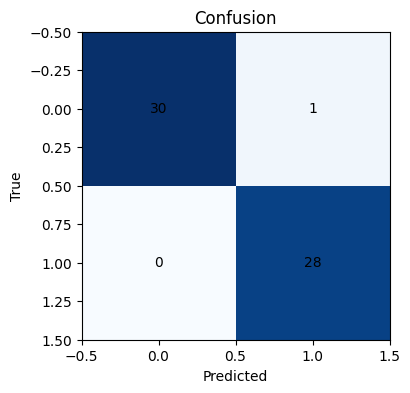

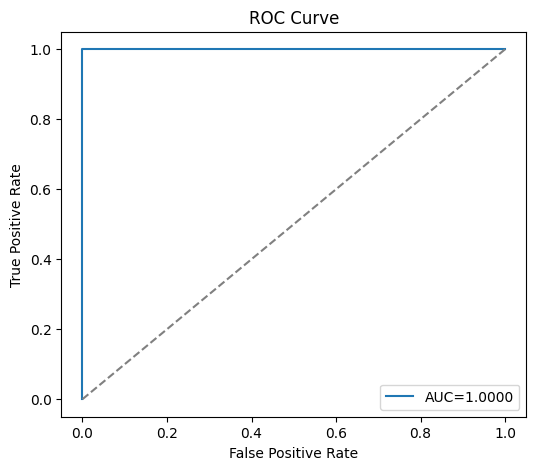

In [25]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Memory
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

def make_poly(interaction_only=True, include_bias=False):
    try:
        return PolynomialFeatures(interaction_only=interaction_only, include_bias=include_bias, sparse_output=True)
    except TypeError:
        return PolynomialFeatures(interaction_only=interaction_only, include_bias=include_bias)

data = pd.read_csv(r"F:\Dataset\Autism-Adult-Data.csv")
if "Class/ASD" not in data.columns:
    raise RuntimeError("Label column 'Class/ASD' not found")
X_df = data.drop(columns=["Class/ASD"]).copy()
y_raw = data["Class/ASD"].astype(str).str.strip()
mapping = {}
lower_vals = set(v.lower() for v in y_raw.unique())
if lower_vals <= {"yes","no"} or lower_vals & {"yes","no"}:
    mapping = {v:1 for v in y_raw.unique() if v.strip().lower()=="yes"}
    mapping.update({v:0 for v in y_raw.unique() if v.strip().lower()=="no"})
if mapping:
    y = y_raw.map(mapping).astype(int).to_numpy()
else:
    y_numeric = pd.to_numeric(y_raw, errors="coerce")
    if not y_numeric.isna().all():
        y = y_numeric.astype(int).to_numpy()
    else:
        codes, uniques = pd.factorize(y_raw)
        y = codes

num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=[np.number]).columns.tolist()

num_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
try:
    cat_imputer = SimpleImputer(strategy="constant", fill_value="__MISSING__")
except TypeError:
    cat_imputer = SimpleImputer(strategy="constant", fill_value="__MISSING__")
try:
    cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=True)
cat_transformer = Pipeline([("impute", cat_imputer), ("ohe", cat_encoder)])

preproc = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
], remainder="drop", sparse_threshold=0.3)

cache_dir = "./pipeline_cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
mem = Memory(location=cache_dir, verbose=0)

pipe = Pipeline(
    steps=[
        ("pre", preproc),
        ("poly", make_poly(interaction_only=True, include_bias=False)),
        ("clf", LogisticRegression(solver="saga", max_iter=2000, tol=1e-4))
    ],
    memory=mem
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "poly__degree": [1, 2],
    "poly__interaction_only": [True],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=12,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

Xtr, Xte, ytr, yte = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)

print("\nTiming one pipeline fit...")
test_pipe = Pipeline([
    ("pre", preproc),
    ("poly", make_poly(interaction_only=True, include_bias=False)),
    ("clf", LogisticRegression(solver="saga", max_iter=500, tol=1e-3))
])
t0 = time.time()
test_pipe.fit(Xtr[:min(5000, len(Xtr))], ytr[:min(5000, len(ytr))])
print(f"Single-fit time: {time.time()-t0:.2f}s")

print("\nStarting RandomizedSearchCV...")
t0 = time.time()
rs.fit(Xtr, ytr)
print(f"RandomizedSearchCV time: {time.time()-t0:.1f}s")
print("best params:", rs.best_params_)
best = rs.best_estimator_

y_pred = best.predict(Xte)
y_prob = None
if hasattr(best, "predict_proba"):
    try:
        y_prob = best.predict_proba(Xte)[:, 1]
    except Exception:
        y_prob = None

acc = accuracy_score(yte, y_pred)
prec = precision_score(yte, y_pred, zero_division=0)
rec = recall_score(yte, y_pred, zero_division=0)
f1 = f1_score(yte, y_pred, zero_division=0)
auc = np.nan
if (y_prob is not None) and (len(np.unique(yte)) > 1):
    try:
        auc = roc_auc_score(yte, y_prob)
    except Exception:
        auc = np.nan

print("\n=== Results on Test Set ===")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)
print("AUC:", auc)

cm = confusion_matrix(yte, y_pred)
print("Confusion matrix:\n", cm)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion")
plt.xlabel("Predicted")
plt.ylabel("True")
for (r, c), val in np.ndenumerate(cm):
    plt.text(c, r, int(val), ha="center", va="center", color="black")
plt.show()

if (y_prob is not None) and (len(np.unique(yte)) > 1):
    fpr, tpr, _ = roc_curve(yte, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [26]:
class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X):
        n = X.shape[0]
        preds = np.zeros(n, dtype=int)
        for i in range(n):
            dists = np.linalg.norm(self.X_train - X[i], axis=1)
            idx = np.argpartition(dists, self.k)[:self.k]
            vals, counts = np.unique(self.y_train[idx], return_counts=True)
            preds[i] = vals[np.argmax(counts)]
        return preds


In [27]:
import numpy as np

class DecisionTree:
    class Node:
        def __init__(self, gini=None, num_samples=None, num_samples_per_class=None, predicted_class=None):
            self.gini = gini
            self.num_samples = num_samples
            self.num_samples_per_class = num_samples_per_class
            self.predicted_class = predicted_class
            self.feature_index = None
            self.threshold = None
            self.left = None
            self.right = None

    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_classes_ = None
        self.n_features_ = None
        self.tree_ = None

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        p = counts / m
        return 1.0 - np.sum(p**2)

    def _best_split(self, X, y):
        m, n = X.shape
        if m < 2:
            return None, None
        classes = np.unique(y)
        class_to_idx = {c:i for i,c in enumerate(classes)}
        best_gini = 1.0
        best_idx, best_thr = None, None
        feature_indices = np.arange(n)
        if self.max_features is not None:
            if 0 < self.max_features < 1:
                k = max(1, int(self.max_features * n))
            else:
                k = min(int(self.max_features), n)
            feature_indices = np.random.choice(n, k, replace=False)
        for idx in feature_indices:
            col = X[:, idx]
            sort_idx = np.argsort(col)
            X_col = col[sort_idx]
            y_col = y[sort_idx]
            unique_vals = np.unique(X_col)
            if unique_vals.size == 1:
                continue
            left_counts = np.zeros(len(classes), dtype=int)
            right_counts = np.bincount(y_col, minlength=len(classes)).astype(int)
            for i in range(1, m):
                c = y_col[i-1]
                left_counts[class_to_idx[c]] += 1
                right_counts[class_to_idx[c]] -= 1
                if X_col[i] == X_col[i-1]:
                    continue
                left_m = i
                right_m = m - i
                if left_m < self.min_samples_leaf or right_m < self.min_samples_leaf:
                    continue
                g_left = 1.0 - np.sum((left_counts/left_m)**2)
                g_right = 1.0 - np.sum((right_counts/right_m)**2) if right_m>0 else 0.0
                g = (left_m * g_left + right_m * g_right) / m
                if g < best_gini:
                    best_gini = g
                    best_idx = idx
                    best_thr = (X_col[i] + X_col[i-1]) / 2.0
        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        classes, counts = np.unique(y, return_counts=True)
        predicted_class = int(classes[np.argmax(counts)])
        node = self.Node(gini=self._gini(y), num_samples=len(y), num_samples_per_class=counts.tolist(), predicted_class=predicted_class)
        if depth < self.max_depth and len(y) >= self.min_samples_split and node.gini > 0.0:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                left_mask = X[:, idx] <= thr
                X_left, y_left = X[left_mask], y[left_mask]
                X_right, y_right = X[~left_mask], y[~left_mask]
                if len(y_left) >= self.min_samples_leaf and len(y_right) >= self.min_samples_leaf and len(y_left)>0 and len(y_right)>0:
                    node.feature_index = int(idx)
                    node.threshold = float(thr)
                    node.left = self._build_tree(X_left, y_left, depth + 1)
                    node.right = self._build_tree(X_right, y_right, depth + 1)
        return node

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._build_tree(X, y)

    def _predict_one(self, inputs):
        node = self.tree_
        while node.left is not None and node.right is not None:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return int(node.predicted_class)

    def predict(self, X):
        return np.array([self._predict_one(x) for x in X])

    def _predict_proba_one(self, inputs):
        node = self.tree_
        while node.left is not None and node.right is not None:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        counts = np.array(node.num_samples_per_class, dtype=float)
        probs = counts / counts.sum() if counts.sum()>0 else np.ones(self.n_classes_)/self.n_classes_
        return probs

    def predict_proba(self, X):
        probs = np.vstack([self._predict_proba_one(x) for x in X])
        return probs


In [28]:
def evaluate_scratch_model(model, X_train, y_train, X_test, y_test, fit=True):
    if fit:
        model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
        if probs.ndim == 2:
            pos_probs = probs[:, 1]
        else:
            pos_probs = probs
    else:
        try:
            pos_probs = None
            preds = model.predict(X_test)
        except Exception:
            preds = model.predict(X_test)
    if 'preds' not in locals():
        preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    auc = roc_auc_score(y_test, pos_probs) if (pos_probs is not None and len(np.unique(y_test))>1) else float('nan')
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc}, preds, pos_probs

In [29]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE).long()
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total += X_batch.size(0)
    avg_loss = total_loss / total if total > 0 else 0.0
    avg_acc = total_correct / total if total > 0 else 0.0
    return avg_loss, avg_acc

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE).long()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            probs = torch.softmax(logits, dim=1)[:, 1]
            total_correct += (preds == y_batch).sum().item()
            total += X_batch.size(0)
            y_true.extend(y_batch.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            y_prob.extend(probs.cpu().numpy().tolist())
    avg_loss = total_loss / total if total > 0 else 0.0
    avg_acc = total_correct / total if total > 0 else 0.0
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = float("nan")
    return {"loss": avg_loss, "acc": avg_acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc}

,Model,Accuracy,Precision,Recall,F1,AUC
0,KNN,1.0,1.0,1.0,1.0,NaN
1,DecisionTreeScratch,1.0,1.0,1.0,1.0,0.5


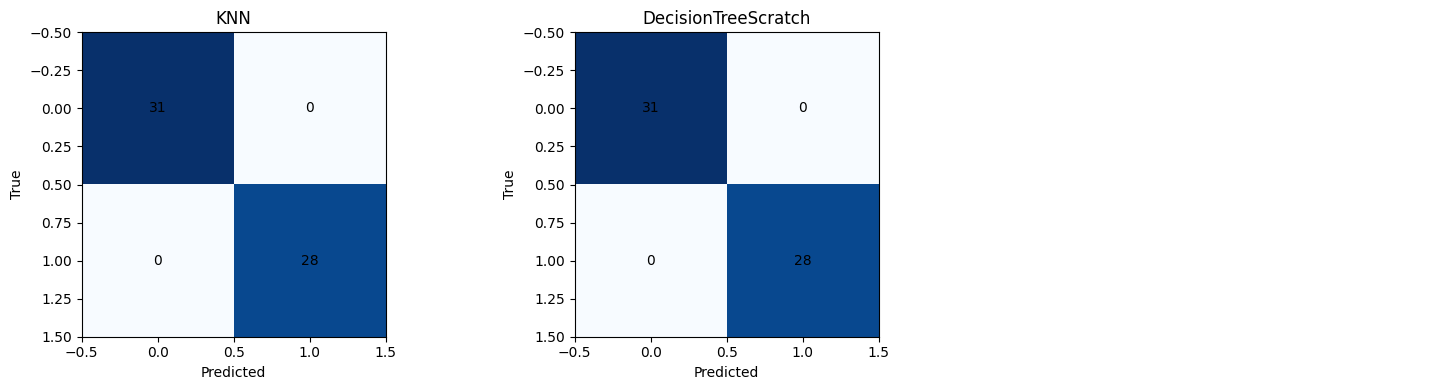

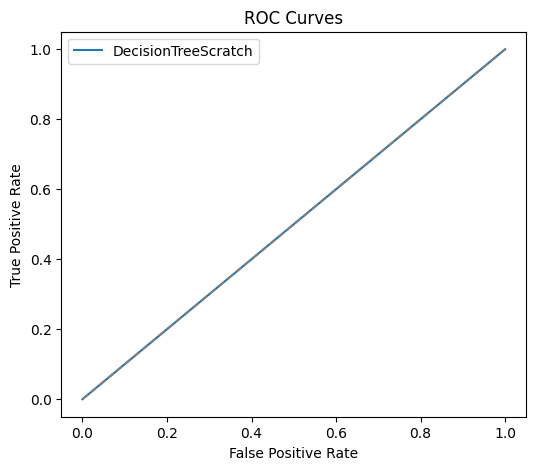

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv(r"F:\Dataset\Autism-Adult-Data.csv")
y_raw = df["Class/ASD"].astype(str).str.strip()
lower_vals = set(v.lower() for v in y_raw.unique())
if lower_vals <= {"yes","no"} or lower_vals & {"yes","no"}:
    y = y_raw.str.lower().map({"yes":1, "no":0}).astype(int)
else:
    y_num = pd.to_numeric(y_raw, errors="coerce")
    if not y_num.isna().all():
        y = y_num.astype(int)
    else:
        y = pd.Series(pd.factorize(y_raw)[0], index=y_raw.index)

X = df.drop(columns=["Class/ASD"]).copy()
X = pd.get_dummies(X, drop_first=True)
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)

X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = np.asarray(y_train).astype(int)
y_test = np.asarray(y_test).astype(int)

scratch_models = {
    "KNN": KNN(k=30),
    "DecisionTreeScratch": DecisionTree(max_depth=6),
}

results, plot_info = [], []

for name, model in scratch_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_test)
            if y_prob.ndim > 1 and y_prob.shape[1] > 1:
                y_prob = y_prob[:,1]
        except Exception:
            y_prob = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    except Exception:
        auc = np.nan
    results.append([name, acc, prec, rec, f1, auc])
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr = None, None
    if y_prob is not None and len(np.unique(y_test)) > 1:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
    plot_info.append((name, cm, fpr, tpr))

df_results = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","AUC"])
display(df_results)

n, cols = len(plot_info), 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols,4*rows))
axes = np.array(axes).reshape(-1)
for i, (name, cm, fpr, tpr) in enumerate(plot_info):
    ax = axes[i]
    ax.imshow(cm, cmap="Blues")
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    for (r,c), val in np.ndenumerate(cm):
        ax.text(c, r, int(val), ha="center", va="center", color="black")
for j in range(len(plot_info), len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
for name, cm, fpr, tpr in plot_info:
    if fpr is not None:
        plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [31]:
class SVM:
    def __init__(self, lambda_reg=1e-4, epochs=100, batch_size=32, seed=42):
        self.lambda_reg = float(lambda_reg)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.seed = int(seed)
        self.w = None
        self.b = 0.0
    def _hinge_grad(self, X, y, w, b, lambda_reg):
        n = X.shape[0]
        margins = y * (X.dot(w) + b)
        idx = margins < 1.0
        grad_w = lambda_reg * w - (1.0 / n) * (X[idx].T.dot(y[idx])) if idx.any() else lambda_reg * w
        grad_b = - (1.0 / n) * np.sum(y[idx]) if idx.any() else 0.0
        return grad_w, grad_b
    def fit(self, X, y):
        rng = np.random.RandomState(self.seed)
        n, d = X.shape
        self.w = np.zeros(d, dtype=float)
        self.b = 0.0
        t = 0
        for epoch in range(self.epochs):
            perm = rng.permutation(n)
            for i in range(0, n, self.batch_size):
                t += 1
                lr = 1.0 / (self.lambda_reg * t)
                batch_idx = perm[i:i+self.batch_size]
                Xb = X[batch_idx]
                yb = y[batch_idx]
                margins = yb * (Xb.dot(self.w) + self.b)
                mask = margins < 1.0
                if mask.any():
                    subgrad_w = self.lambda_reg * self.w - (1.0 / len(Xb)) * (Xb[mask].T.dot(yb[mask]))
                    subgrad_b = - (1.0 / len(Xb)) * np.sum(yb[mask])
                else:
                    subgrad_w = self.lambda_reg * self.w
                    subgrad_b = 0.0
                self.w -= lr * subgrad_w
                self.b -= lr * subgrad_b
                norm = np.linalg.norm(self.w)
                proj = min(1.0, (1.0/np.sqrt(self.lambda_reg)) / (norm + 1e-12))
                self.w *= proj
    def decision_function(self, X):
        return X.dot(self.w) + self.b
    def predict(self, X):
        return (self.decision_function(X) >= 0.0).astype(int)
    def predict_proba(self, X):
        d = self.decision_function(X)
        p = 1.0 / (1.0 + np.exp(-d))
        return p

,Model,Accuracy,Precision,Recall,F1,AUC
0,SVM,1.0,1.0,1.0,1.0,1.0


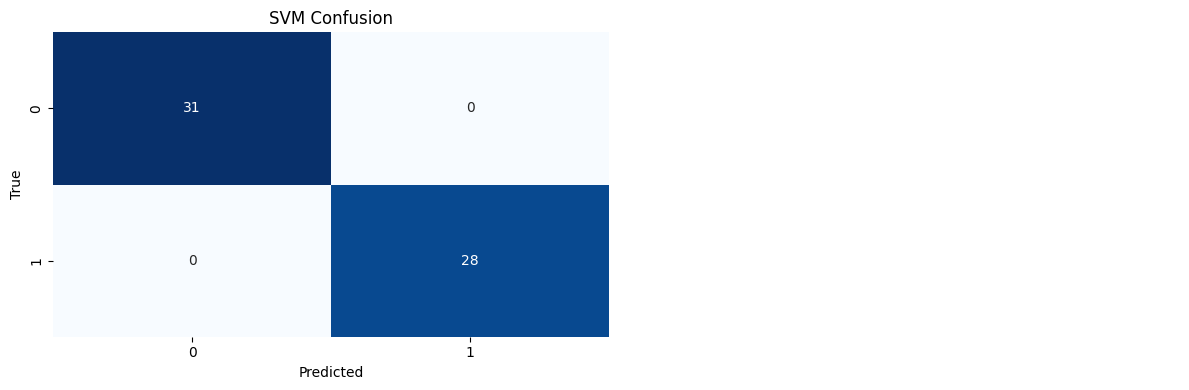

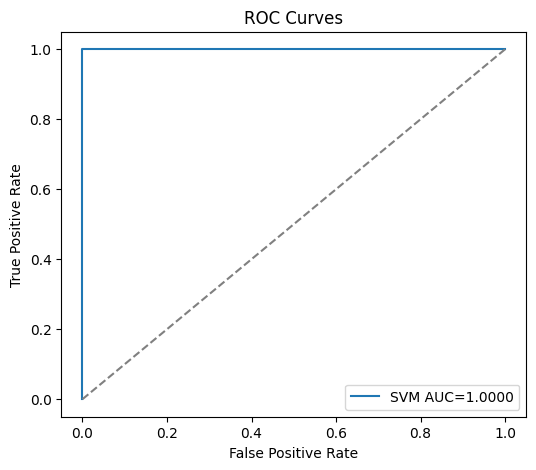

In [32]:
csv_path = r"F:\Dataset\Autism-Adult-Data.csv"
df = pd.read_csv(csv_path).dropna(axis=0, how='all').reset_index(drop=True)
label_col = "Class/ASD"
df[label_col] = df[label_col].astype(str).str.strip().map({"yes":1,"no":0,"Yes":1,"No":0}).fillna(df[label_col])
le = LabelEncoder()
for c in df.columns:
    if df[c].dtype == object and c != label_col:
        df[c] = df[c].astype(str).str.strip()
        df[c] = le.fit_transform(df[c])
df = df.fillna(df.mean(numeric_only=True))
y = df[label_col].astype(int).values
X = df.drop(columns=[label_col]).values.astype(float)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
svm = SVM(lambda_reg=1e-3, epochs=300, batch_size=32, seed=42)
svm.fit(X_train, np.where(y_train==1, 1, -1))
svm_y_pred = svm.predict(X_test)
svm_y_prob = svm.predict_proba(X_test)
models = [
    ("SVM", svm_y_pred, svm_y_prob),
]
rows = []
for name, y_pred, y_prob in models:
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = np.nan
    try:
        if y_prob is not None and len(np.unique(y_test))>1:
            auc = roc_auc_score(y_test, y_prob)
    except Exception:
        auc = np.nan
    rows.append([name, acc, prec, rec, f1, auc])
results_df = pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1","AUC"])
display(results_df)
n = len(models)
cols = 2
rows_plot = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows_plot, cols, figsize=(6*cols,4*rows_plot))
axes = np.array(axes).reshape(-1)
for i, (name, y_pred, y_prob) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(name + " Confusion")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,5))
for name, y_pred, y_prob in models:
    if y_prob is not None and len(np.unique(y_test))>1:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc_score(y_test,y_prob):.4f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [33]:
import numpy as np

class CNN:
    def __init__(self, input_dim, num_filters=8, filter_size=3, hidden_dim=32,lr=0.01, epochs=200, batch_size=16, seed=42):
        np.random.seed(seed)
        self.input_dim = input_dim
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.filters = np.random.randn(num_filters, filter_size) * 0.1
        self.conv_bias = np.zeros(num_filters)
        conv_out_len = input_dim - filter_size + 1
        self.W1 = np.random.randn(num_filters * conv_out_len, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, 1) * 0.1
        self.b2 = np.zeros(1)
        self.loss_history = []

    def _conv1d(self, x):
        n = len(x)
        out_len = n - self.filter_size + 1
        out = np.zeros((self.num_filters, out_len))
        for f in range(self.num_filters):
            for i in range(out_len):
                out[f, i] = np.sum(x[i:i+self.filter_size] * self.filters[f]) + self.conv_bias[f]
        return out.flatten()

    def _conv1d_map(self, x):
        n = len(x)
        out_len = n - self.filter_size + 1
        out = np.zeros((self.num_filters, out_len))
        for f in range(self.num_filters):
            for i in range(out_len):
                out[f, i] = np.sum(x[i:i+self.filter_size] * self.filters[f]) + self.conv_bias[f]
        return out

    def forward(self, X):
        conv_maps = [self._conv1d_map(x) for x in X]
        conv_out = np.array([cm.flatten() for cm in conv_maps])
        z1 = conv_out.dot(self.W1) + self.b1
        a1 = np.maximum(0, z1)
        z2 = a1.dot(self.W2) + self.b2
        probs = 1 / (1 + np.exp(-z2))
        return conv_maps, conv_out, z1, a1, z2, probs

    def fit(self, X, y):
        n = X.shape[0]
        for epoch in range(self.epochs):
            perm = np.random.permutation(n)
            X_shuf = X[perm]
            y_shuf = y[perm].reshape(-1, 1)
            batch_losses = []
            for i in range(0, n, self.batch_size):
                Xb = X_shuf[i:i+self.batch_size]
                yb = y_shuf[i:i+self.batch_size]
                if len(Xb) == 0:
                    continue
                conv_maps, conv_out, z1, a1, z2, probs = self.forward(Xb)
                loss = -np.mean(yb * np.log(probs + 1e-12) + (1 - yb) * np.log(1 - probs + 1e-12))
                batch_losses.append(loss)
                m = len(Xb)
                dz2 = probs - yb
                dW2 = a1.T.dot(dz2) / m
                db2 = np.mean(dz2, axis=0)
                da1 = dz2.dot(self.W2.T)
                dz1 = da1 * (z1 > 0)
                dW1 = conv_out.T.dot(dz1) / m
                db1 = np.mean(dz1, axis=0)
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1
                da_conv_flat = dz1.dot(self.W1.T)
                out_len = self.input_dim - self.filter_size + 1
                da_conv = da_conv_flat.reshape(m, self.num_filters, out_len)
                grad_filters = np.zeros_like(self.filters)
                grad_conv_bias = np.zeros_like(self.conv_bias)
                for sample_idx in range(m):
                    x = Xb[sample_idx]
                    for f in range(self.num_filters):
                        for pos in range(out_len):
                            grad_filters[f] += da_conv[sample_idx, f, pos] * x[pos:pos + self.filter_size]
                            grad_conv_bias[f] += da_conv[sample_idx, f, pos]
                grad_filters /= m
                grad_conv_bias /= m
                self.filters -= self.lr * grad_filters
                self.conv_bias -= self.lr * grad_conv_bias
            if len(batch_losses) > 0:
                self.loss_history.append(np.mean(batch_losses))
            else:
                self.loss_history.append(0.0)

    def predict_proba(self, X):
        _, _, _, _, _, probs = self.forward(X)
        return probs.flatten()

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [34]:
cnn = CNN(input_dim=X_train.shape[1], num_filters=8, filter_size=3, hidden_dim=32, lr=0.08, epochs=400, batch_size=16)
cnn.fit(X_train, y_train)

y_pred = cnn.predict(X_test)
y_prob = cnn.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

results_df = pd.DataFrame([[acc,prec,rec,f1,auc]], columns=["Accuracy","Precision","Recall","F1","AUC"])
display(results_df)

,Accuracy,Precision,Recall,F1,AUC
0,1.0,1.0,1.0,1.0,1.0


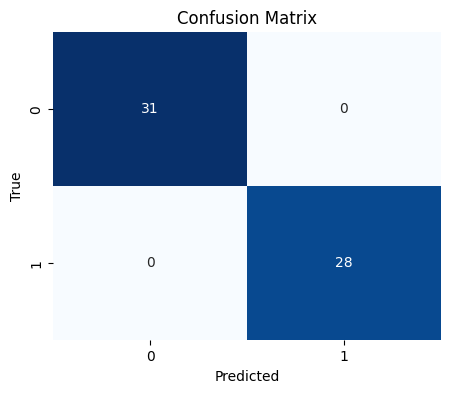

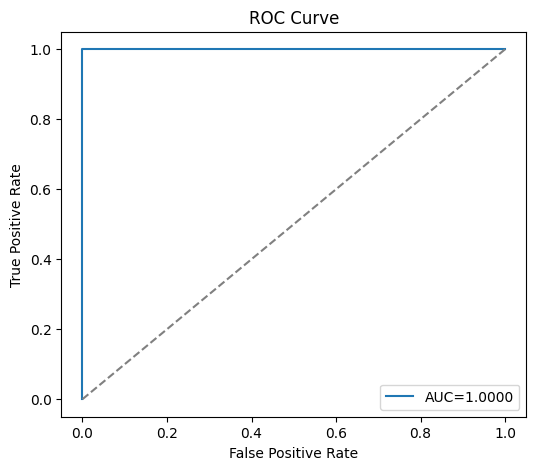

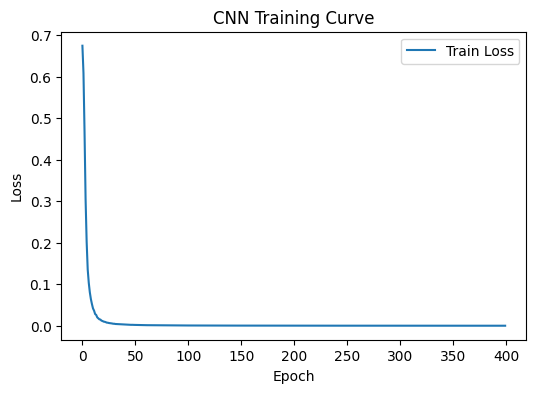

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(cnn.loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training Curve")
plt.legend()
plt.show()